# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных:

- DateCrawled — дата скачивания анкеты из базы;
- VehicleType — тип автомобильного кузова;
- RegistrationYear — год регистрации автомобиля;
- Gearbox — тип коробки передач;
- Power — мощность (л. с.);
- Model — модель автомобиля;
- Kilometer — пробег (км);
- RegistrationMonth — месяц регистрации автомобиля;
- FuelType — тип топлива;
- Brand — марка автомобиля;
- Repaired — была машина в ремонте или нет;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя.

Целевой признак:
- Price — цена (евро)

Для выполнения проекта необходимо будет выполнить следующие этапы:

- Подготовка данных (загрузка данных, предобработка данных, исследовательский анализ данных, корреляционный анализ данных);
- Обучение моделей;
- Анализ моделей;
- Выводы

In [1]:
# установка модуля phik
!pip install phik -q

In [2]:
import phik
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from time import time
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score
)

## Подготовка данных

### Загрузка данных

In [3]:
#считывание csv-файла и сохранение в датафрейм
autos = pd.read_csv('/datasets/autos.csv')

In [4]:
# получение первых 10 строк датафрейма autos
autos.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
# вывод основной информации о датафрейме autos
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Вывод: Были загружены и изучены данные из датафрейма autos.

### Предобработка данных

In [6]:
# приведение всех столбцов датафрейма autos к нижнему регистру
autos.columns = autos.columns.str.lower()

In [7]:
# переименование столбцов датафрейма autos
autos = autos.rename(columns={'datecrawled':'date_crawled', 
                            'vehicletype':'vehicle_type', 
                            'registrationyear':'registration_year',
                            'registrationmonth':'registration_month',
                            'fueltype':'fuel_type', 
                            'datecreated':'date_created', 
                            'numberofpictures':'number_of_pictures', 
                            'postalcode':'postal_code',
                            'lastseen':'last_seen'})

In [8]:
# изменение типа данных в столбцах date_crawled, date_created, last_seen
autos['date_crawled'] = pd.to_datetime(autos['date_crawled'], format = '%Y-%m-%d %H:%M:%S')
autos['date_created'] = pd.to_datetime(autos['date_created'], format = '%Y-%m-%d %H:%M:%S')
autos['last_seen'] = pd.to_datetime(autos['last_seen'], format = '%Y-%m-%d %H:%M:%S')

In [9]:
# подсчет количества пропусков в датафрейме autos
autos.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [10]:
# замена пропусков на значение unknown
autos['vehicle_type'] = autos['vehicle_type'].fillna('unknown')
autos['gearbox'] = autos['gearbox'].fillna('unknown')
autos['model'] = autos['model'].fillna('unknown')
autos['fuel_type'] = autos['fuel_type'].fillna('unknown')
autos['repaired'] = autos['repaired'].fillna('unknown')

In [11]:
autos['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

In [12]:
autos = autos[(autos['date_created'] < '2016-04-07 14:36:58')]

In [13]:
# удалим неинформативные столбцы date_crawled, date_created, number_of_pictures, postal_code, last_seen 
autos = autos.drop(columns=['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'])

In [14]:
# определение количества дубликатов в датафрейме autos
autos.duplicated().sum()

27543

In [15]:
# удаление дубликатов в датафрейме autos
autos = autos.drop_duplicates().reset_index()

Вывод: на этапе предобработки данных названия столбцов были приведены к нижнему регистру. В столбцах date_crawled, date_created, last_seen был изменен тип даннх на datetime. Также были заполнены пропущенные значения в столбцах vehicle_type, gearbox, model, fuel_type, repaired и удалены дубликаты.

### Исследовательский анализ данных

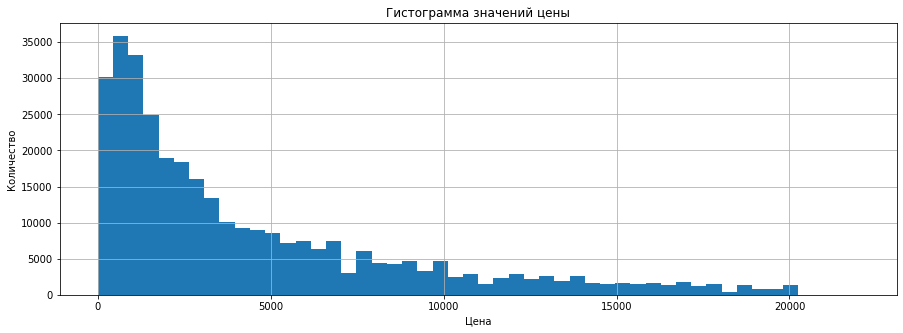

In [16]:
# построение гистограммы по столбцу price
autos['price'].hist(bins=50, range = (0, 22000), figsize=(15, 5))
plt.title('Гистограмма значений цены')
plt.xlabel('Цена')
plt.ylabel('Количество');

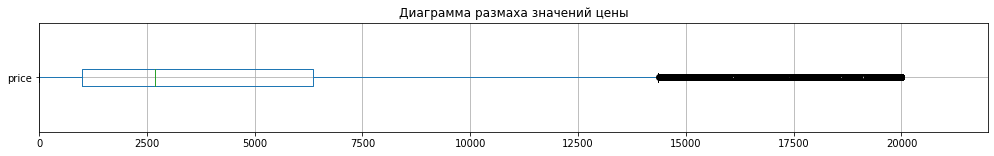

In [17]:
# построение диаграммы размаха по столбцу удой_кг
fig, ax = plt.subplots(figsize = (17,2))
ax = autos[['price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений цены')
ax.set_xlim(0, 22000);

In [18]:
# вывод числового описания данных 
autos['price'].describe()

count    326826.000000
mean       4403.747330
std        4518.209808
min           0.000000
25%        1000.000000
50%        2700.000000
75%        6350.000000
max       20000.000000
Name: price, dtype: float64

In [19]:
# срез по столбцу price
autos = autos[(autos['price'] > 100)]

По полученным графикам можно сказать, что большое количество автомобилей продаются за цену менее 1 евро, что является аномалией, также по диаграмме размаха видно, что после значения цены в 14500 евро начинаются выбросы. 

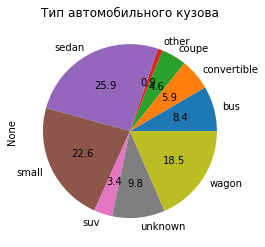

In [20]:
# построение круговой диаграммы
autos.groupby('vehicle_type').size().plot(kind='pie', autopct='%.1f')
plt.title('Тип автомобильного кузова');

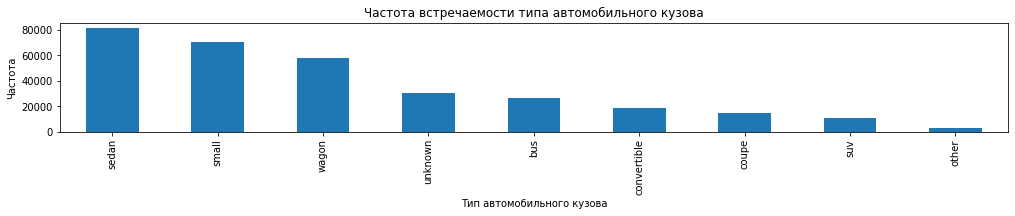

In [21]:
# построение столбчатой диаграммы по столбцу vehicle_type
autos['vehicle_type'].value_counts().plot(kind='bar', figsize = (17,2))
plt.title('Частота встречаемости типа автомобильного кузова')
plt.xlabel('Тип автомобильного кузова')
plt.ylabel('Частота');

По данной круговой диаграмме видно, что 2/3 объявлений составляют автомобили с кузовами sedan, small и wagon.  

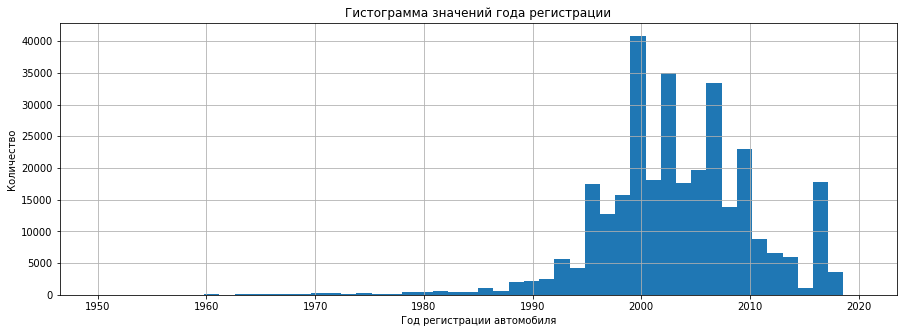

In [22]:
# построение гистаграммы по столбцу registration_year
autos['registration_year'].hist(bins=50, range = (1950, 2020), figsize=(15, 5))
plt.title('Гистограмма значений года регистрации')
plt.xlabel('Год регистрации автомобиля')
plt.ylabel('Количество');

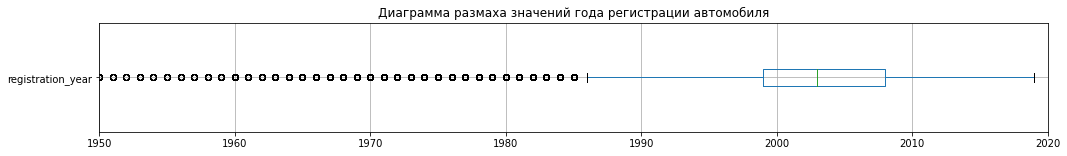

In [23]:
# построение диаграммы размаха по столбцу registration_year
fig, ax = plt.subplots(figsize = (17,2))
ax = autos[['registration_year']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений года регистрации автомобиля')
ax.set_xlim(1950, 2020);

In [24]:
# вывод числового описания данных 
autos['registration_year'].describe()

count    314059.000000
mean       2003.973604
std          71.785991
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [25]:
# срез по столбцу registration_year
autos = autos[(autos['registration_year'] > 1985)]

По полученным данным можно сказать, что минимальное и максимальное значения года регистрации невозможны, поэтому необходимо было сделать срез на основании имеющихся графиков и данных.

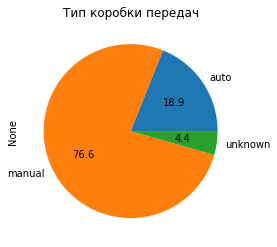

In [26]:
# построение круговой диаграммы
autos.groupby('gearbox').size().plot(kind='pie', autopct='%.1f')
plt.title('Тип коробки передач');

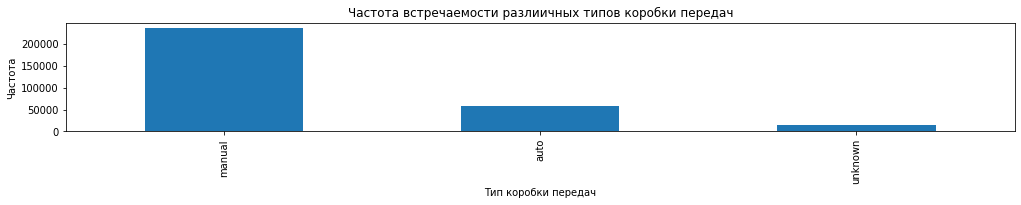

In [27]:
# построение столбчатой диаграммы по столбцу gearbox
autos['gearbox'].value_counts().plot(kind='bar', figsize = (17,2))
plt.title('Частота встречаемости разлиичных типов коробки передач')
plt.xlabel('Тип коробки передач')
plt.ylabel('Частота');

Данная круговая диаграмма показывает, что большая часть автомобилей имеет механическую коробку передач.

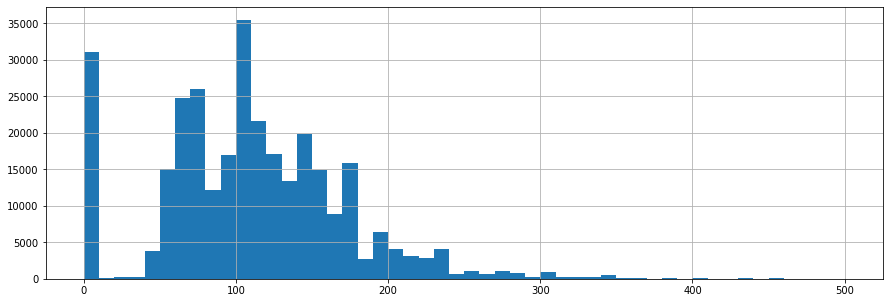

In [28]:
# построение гистаграммы по столбцу power
autos['power'].hist(bins=50, range = (0, 500), figsize=(15, 5));

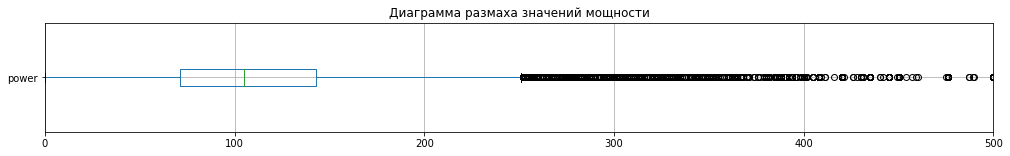

In [29]:
# построение диаграммы размаха по столбцу power
fig, ax = plt.subplots(figsize = (17,2))
ax = autos[['power']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений мощности')
ax.set_xlim(0, 500);

In [30]:
# вывод числового описания данных 
autos['power'].describe()

count    308774.000000
mean        112.114226
std         193.512070
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [31]:
# срез по столбцу power
autos = autos[(autos['power'] > 10) & (autos['power'] < 300)]

Данные показывают, что в столбце power есть выбросы при значениях более 250, а также есть значения равные нулю, чего быть не может.

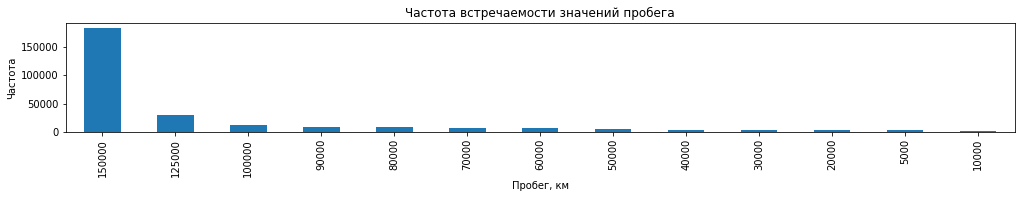

In [32]:
# построение столбчатой диаграммы по столбцу kilometer
autos['kilometer'].value_counts().plot(kind='bar', figsize = (17,2))
plt.title('Частота встречаемости значений пробега')
plt.xlabel('Пробег, км')
plt.ylabel('Частота');

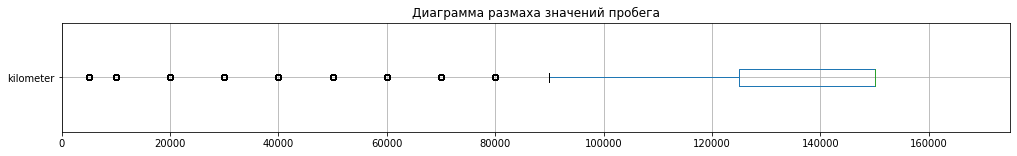

In [33]:
# построение диаграммы размаха по столбцу kilometer
fig, ax = plt.subplots(figsize = (17,2))
ax = autos[['kilometer']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений пробега')
ax.set_xlim(0, 175000);

Данные по пробегу показывают, что среднее значение пробега равно 130000 км, а медиана 150000 км, что совпадает с максимальным значением пробега.

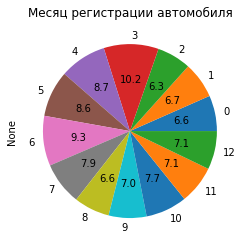

In [34]:
# построение круговой диаграммы
autos.groupby('registration_month').size().plot(kind='pie', autopct='%.1f')
plt.title('Месяц регистрации автомобиля');

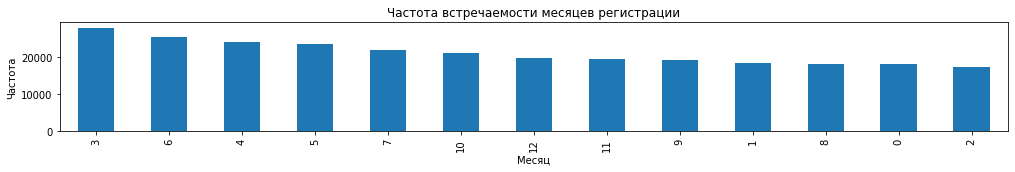

In [35]:
# построение столбчатой диаграммы по столбцу registration_month
autos['registration_month'].value_counts().plot(kind='bar', figsize = (17,2))
plt.title('Частота встречаемости месяцев регистрации')
plt.xlabel('Месяц')
plt.ylabel('Частота');

По полученной круговой диаграмме видно, что распределение анкет автомобилей по месяцам равномерное.

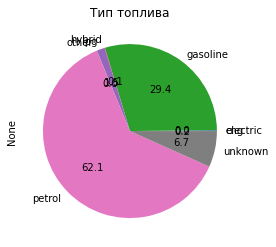

In [36]:
# построение круговой диаграммы
autos.groupby('fuel_type').size().plot(kind='pie', autopct='%.1f')
plt.title('Тип топлива');

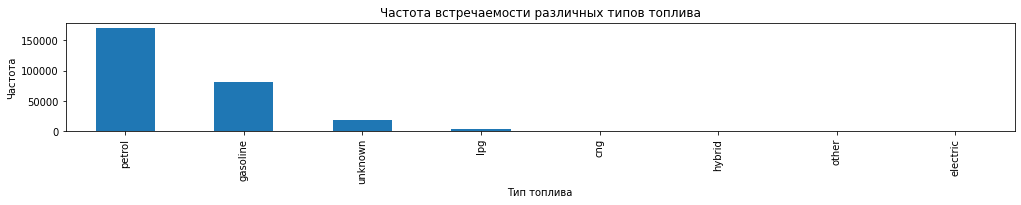

In [37]:
# построение столбчатой диаграммы по столбцу fuel_type
autos['fuel_type'].value_counts().plot(kind='bar', figsize = (17,2))
plt.title('Частота встречаемости различных типов топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Частота');

Полученная круговая диаграмма показывает, что подавляющее большинство (более 90%) составляют автомобили, использующие бензин

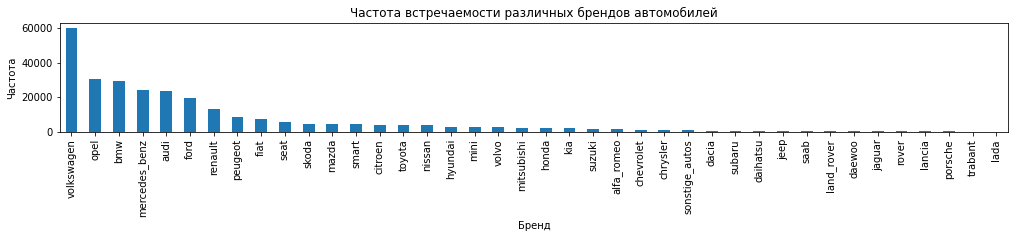

In [38]:
# построение столбчатой диаграммы по столбцу brand
autos['brand'].value_counts().plot(kind='bar', figsize = (17,2))
plt.title('Частота встречаемости различных брендов автомобилей')
plt.xlabel('Бренд')
plt.ylabel('Частота');

По столбчатой диаграмме видно, что в топ-5 брендов входят: Volkswagen, Opel, BMW, Mersedes_Benz, Audi.

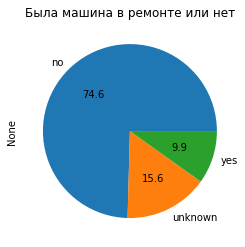

In [39]:
# построение круговой диаграммы
autos.groupby('repaired').size().plot(kind='pie', autopct='%.1f')
plt.title('Была машина в ремонте или нет');

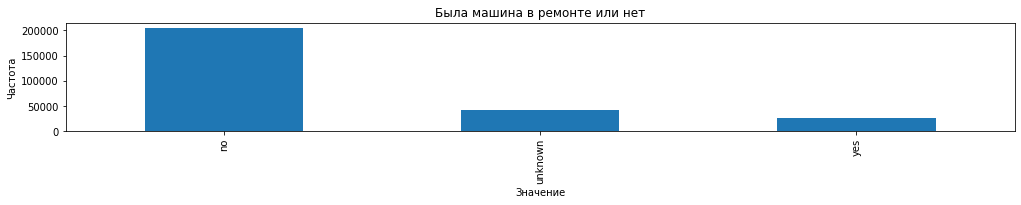

In [40]:
# построение столбчатой диаграммы по столбцу repaired
autos['repaired'].value_counts().plot(kind='bar', figsize = (17,2))
plt.title('Была машина в ремонте или нет')
plt.xlabel('Значение')
plt.ylabel('Частота');

Данная круговая диаграмма показывает, что 75% машин не были в ремонте.

Вывод: в процессе исследовательского анализа были построены графики для некоторых параметров. Исходя из графика цены было выяснено, что большое количество обявлений имеют цену менее 1 евро, что явлется аномалией. Также были выявлены и удалены аномалии в столбцах registration_year и power.\
2/3 объявлений составляют автомобили с кузовами sedan, small и wagon. 76.9% автомобилей имеют механическую коробку передач. 90% автомобилей функционируют на бензине. 75% машин не были в ремонте. 

### Корреляционный анализ

In [41]:
# опредление коэффициентов с помощью phik_matrix()
autos[['price',
            'vehicle_type',
            'registration_year',
            'gearbox',
            'power',
            'model',
            'kilometer',
            'registration_month',
            'fuel_type',
            'brand',
            'repaired']
].phik_matrix(interval_cols=['price', 'kilometer'])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
price,1.000000,0.261767,0.667070,0.273442,0.620136,0.574899,0.321417,0.128440,0.268474,0.354840,0.335258
vehicle_type,0.261767,1.000000,0.681143,0.367004,0.677708,0.897190,0.254583,0.186289,0.417015,0.587773,0.354563
registration_year,0.667070,0.681143,1.000000,0.205821,0.679916,0.635592,0.616807,0.208773,0.446441,0.303124,0.362591
gearbox,0.273442,0.367004,0.205821,1.000000,0.606552,0.619231,0.055320,0.178240,0.209361,0.511586,0.278192
power,0.620136,0.677708,0.679916,0.606552,1.000000,0.968465,0.365097,0.145134,0.620344,0.915284,0.270029
model,0.574899,0.897190,0.635592,0.619231,0.968465,1.000000,0.439604,0.180811,0.547215,0.998076,0.273942
kilometer,0.321417,0.254583,0.616807,0.055320,0.365097,0.439604,1.000000,0.077153,0.157580,0.268850,0.229943
registration_month,0.128440,0.186289,0.208773,0.178240,0.145134,0.180811,0.077153,1.000000,0.178671,0.083037,0.312275
fuel_type,0.268474,0.417015,0.446441,0.209361,0.620344,0.547215,0.157580,0.178671,1.000000,0.338965,0.199450
brand,0.354840,0.587773,0.303124,0.511586,0.915284,0.998076,0.268850,0.083037,0.338965,1.000000,0.133019


По результатам корреляционного анализа можно сделать вывод, что целевой признак "price" имеет заметную прямую связь с признаками "registration_year", "power" и "model". Также наблюдается мультиколлинеарность между признаками "power" и "model", между "power" и "brand", между "model" и "brand". 

**Вывод:** На этапе подготовки были изучены и обработаны данные датафрейма autos. В столбцах с пропусками пропуски были заменяны на значения unknown. Были удалены дубликаты. В ходе исследовательского анализа были выявлены и удалены аномалии в столбцах price, registration_year и power. По результатам корреляционного анализа была выявлена заметная прямая связь между целевым признаком price и входными признаками registration_year и power.

## Обучение моделей

In [42]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42

In [43]:
# сохранение входных признаков в переменную X
# сохранение целевого признака в переменную y
X = autos.drop(['index', 'price', 'vehicle_type', 'gearbox', 'registration_month', 'fuel_type'], axis=1)
y = autos['price']

In [44]:
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [45]:
cat_col_names = ['model', 'brand', 'repaired']
num_col_names = ['registration_year', 'power', 'kilometer']

# подготовка признаков (масштабирование и кодирование)

encoder = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [46]:
# обучение модели DecisionTreeRegressor
param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}
dtree_reg = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
best_score_tree = grid_search.best_score_
best_model = grid_search.best_estimator_
print(f"best_score: {-best_score_tree}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   3.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   2.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   3.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   2.9s
[CV] END max_depth=10,

In [47]:
# определение времени обучения модели
start = time()

best_model.fit(X_train, y_train) 

end = time()

time_train = (end-start)/60
print(f"Время обучения: {time_train}")

Время обучения: 0.07496208349863688


In [48]:
# определение времени предсказания модели
start = time()

best_model.predict(X_train)

end = time()

time_train = (end-start)/60
print(f"Время предсказания: {time_train}")

Время предсказания: 0.0036734739939371743


In [49]:
# задание гиперпараметров для модели LGBMRegressor
param_grid = {
    'num_leaves': [20, 31],
    'learning_rate': [0.05, 0.1]
}

# инициализация модели LGBMRegressor
model = lgb.LGBMRegressor()

# обучение модели LGBMRegressor
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error', 
                           cv=5)

grid_search.fit(X_train, y_train)
best_score_LGBM = grid_search.best_score_
print(f"Best_score: {-best_score_LGBM}")

Best_score: 1665.2463871116627


In [50]:
# определение времени обучения модели
best_model_LGBM = grid_search.best_estimator_
start = time()

best_model_LGBM.fit(X_train, y_train) 

end = time()

time_train = (end-start)/60
print(f"Время обучения: {time_train}")

Время обучения: 0.10335572163263956


In [51]:
# определение времени предсказания модели
start = time()

best_model_LGBM.predict(X_train)

end = time()

time_train = (end-start)/60
print(f"Время предсказания: {time_train}")

Время предсказания: 0.045194602012634276


**Вывод:** Были обучены две модели машинного обучения, одна из которых DecisionTreeRegressor, а другая LGBMRegressor. Для каждой модели были проверы разные гиперпараметры и вычислена метрика RMSE с кросс-валидации. Для модели DecisionTreeRegressor метрика равна 1759, а для модели LGBMRegressor - 1665. Также было вычислено время, затраченное на обучение каждой модели и на предсказание. 

## Анализ моделей

По результатам обучения моделей DecisionTreeRegressor и LGBMRegressor можно сделать вывод, что наиболее выгодной моделью является модель DecisionTreeRegressor. Данное решение основано на следующих данных:
* Обе модели прошли по критерию менее 2500 по значению метрики RMSE на кросс-валидации и имеют близкие значения;
* Время обучения и предсказания модели DecisionTreeRegressor ниже, чем у LGBMRegressor, и составляет 0,0747 минут и 0,0037 минут соответственно против 0,13 и 0,04 минут у LGBMRegressor.

In [52]:
# предсказание модели DecisionTreeRegressor на тестовой выборке
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 1729.8877852266726


## Общий вывод:
Были изучены и обработаны данные датафрейма autos. Пропуски были заменены на значения unknown. Были удалены дубликаты.\
В ходе исследовательского анализа были выявлены и удалены аномалии в столбцах price и power. По результатам корреляционного анализа была выявлена заметная прямая связь между целевым признаком price и входными признаками registration_year и power.\
Были обучены две модели машинного обучения, одна из которых DecisionTreeRegressor, а другая LGBMRegressor. Для каждой модели были проверы разные гиперпараметры и вычислена метрика RMSE с кросс-валидации. Для модели DecisionTreeRegressor метрика равна 1759, а для модели LGBMRegressor - 1665. Также было вычислено время, затраченное на обучение каждой модели и на предсказание. Время обучение модели DecisionTreeRegressor ниже, чем у LGBMRegressor, поэтому в результате полученных данных был сделан вывод, что модель DecisionTreeRegressor является наиболее подходящей для решения задачи определения рыночной стоимости автомобиля.
В итоге модель DecisionTreeRegressor была применена для предсказаний на тестовой выборке и показала значение метрики RMSE, равное 1730 евро, что удовлетворяет критерию менее 2500 евро и доказывает успех в обучении модели.